## Exploratory data analysis & Feature extraction

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('spam.csv')
df.head(3)

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam


The values of the target column are:

In [2]:
df['target'].unique().tolist()

['ham', 'spam']

There are no missing values to be drop, so the target column can be directly encoded into binary values:  
    1 -> 'spam'  
    0 -> 'ham'  (e.g. no-spam)

In [3]:
df['target'] = np.where(df['target']=='spam',1,0)
df.head(3)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1


The data set is imbalanced, being the spam messages only a fraction of the full data set:

In [4]:
df['target'].astype('category').describe()

count     5572
unique       2
top          0
freq      4825
Name: target, dtype: int64

In [5]:
spam_examples = df[df['target']==1].index
nospam_examples = df[df['target']==0].index
ratio = 100 * len(spam_examples) / len(df)
print('Fraction of spam examples: {:0.2f}%'.format(ratio))

Fraction of spam examples: 13.41%


Just for curiosity, let's check some spam and non-spam examples:

In [6]:
print('*********** Examples of spam messages ***********')
for i in spam_examples[:3]:
    print(df.loc[i,"text"]+'\n')
print('*********** Examples of no-spam  messages ***********')
for i in nospam_examples[:3]:
    print(df.loc[i,"text"]+'\n')
print('******************************************************')

*********** Examples of spam messages ***********
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

*********** Examples of no-spam  messages ***********
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Ok lar... Joking wif u oni...

U dun say so early hor... U c already then say...

******************************************************


Despite the samples shown above are not statistically representative of the full spam & non-spam sets, they provide some hints:  
    - Spam messages seem to be longer
    - Numerical and non-aplhanumeric characters seem to be more frequent in spam messages
    - Both spam and non-spam seem to use slang and abbreviations
    - Misspelling happens in both spam and non-spam samples

Let's dig into these hypotheses.

Text columns can be nicely handled using the `.str` pandas method which allows the use of Python built-in methods for strings, as well as RegEx searchs:

In [7]:
# regex cheat sheet for python: https://www.debuggex.com/cheatsheet/regex/python
df['msg_len']  = df['text'].str.len()
df['non_word_char'] = df["text"].str.count(r'\W')

The `.apply` + *lambda function* strategy is often useful for building complex operations on a dataframe. However, whenever an easier way to perform the task is available then one should go for it, as the speed performance is important working with larger datasets:

In [8]:
# .apply + lambda to count digits:
digit_counter = lambda text: sum([ x.isdigit() for x in  list(text)])
%time df['text'].apply( digit_counter )
# same operation using .count built-in str method: 
%time df["text"].str.count(r'\d')

df['num_chars'] = df["text"].str.count(r'\d')

CPU times: user 46 ms, sys: 2.51 ms, total: 48.5 ms
Wall time: 47.8 ms
CPU times: user 9.23 ms, sys: 0 ns, total: 9.23 ms
Wall time: 9.09 ms


Let's plot these variables just created on a **pairplot**, which provides direct information about the statistical distribution of each variable and their mutual correlations:

<IPython.core.display.Javascript object>


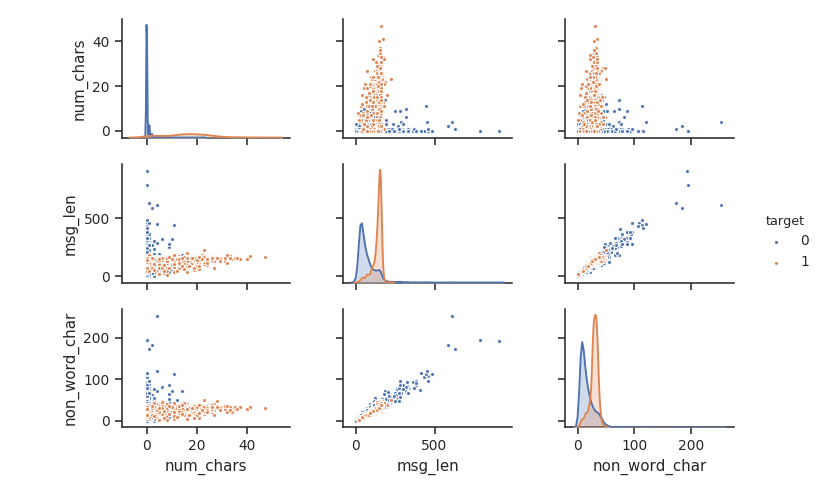

In [9]:
%matplotlib notebook
import seaborn as sns

sns.set(style="ticks", color_codes=True)
#sns.catplot(y='target', x="msg_len",kind="violin",data=df,orient="horizontal")
sns.pairplot(vars=['num_chars','msg_len','non_word_char'],hue='target',diag_kind='kde',height=2,data=df,
             plot_kws=dict(s=10))

The plots on the diagonals show the normalized kernel distribution of each variable, and distinguished by target value. Clearly, the distributions of these 3 variables differ for spam and non-spam examples, therefore, they can be useful features for a learning model.  

Furthermore, the number of numerical characters seem to have low dependency on the number of non-word characters or the message length. It is also seen that the larger the message the larger the number of non-word chars.  

From now on, only training data will be used. Notice that the `train_test_split` function splits data randomly but preserving the same *imbalance* of target values both in the training and test sets:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], random_state=0, train_size = 0.8)

In [11]:
print("ratio of spam/no-spam msgs for training data: {:0.3f}".format(y_train.sum()/len(y_train) ))
print("ratio of spam/no-spam msgs for test data: {:0.3f}".format(y_test.sum()/len(y_test) ) )

ratio of spam/no-spam msgs for training data: 0.130
ratio of spam/no-spam msgs for test data: 0.149


### Feature extraction with a Bag-of-Words (BOW) representation  
The features previously derived give general properties of a SMS message not much related with its text content. For such task, lets obtain numerical features using a *Bag-of-Words* representation. Recall that in this schema, each document of the corpus is vectorized (e.g. represented as a numerical vector), with each component encoding the information whether an specific token (word, sentence, n-gram) of the corpus vocabulary is present or not, as well as some counting criteria. A concise description can be found on the sklearn user guide [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

The `CountVectorizer` class implements both tokenization and occurrence counting. With the default parameters, the document characters are lowercased and then tokenized as words (e.g. matches of the pattern `'\b\w\w+\b'`). Standard *word separators* for english language defined in skln are skipped.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

default_vec = CountVectorizer().fit(X_train)
def_voc_len = len(default_vec.vocabulary_)
print("Vocabulary length after tokenizing with default params: {}".format( def_voc_len ) )

Vocabulary length after tokenizing with default params: 7612


Lets check the frecuency distribution of these tokens across the training corpus:

In [16]:
# vectorize the training data
X_tt = default_vec.transform(X_train)
train_corp_frec = pd.DataFrame(index= default_vec.vocabulary_.values(),
                                        data = default_vec.vocabulary_.keys()
                                       )
train_corp_frec.columns = ['tokens']
# count token frecuencies and place the information on a dataframe
cc = X_tt.sum(axis=0)
train_corp_frec ["corpus_frecuency"] = np.asarray(cc).reshape(-1)
#sorting dataframe by descending frecuencies values
train_corp_frec.sort_values(ascending=False,by="corpus_frecuency",inplace=True)
train_corp_frec[:10]

,tokens,corpus_frecuency
5593,renewing,1785
7511,xoxo,1767
3483,hum,1052
3757,jiu,784
5900,sends,755
4420,miracle,711
3194,grooved,625
6265,spirit,620
3739,jeans,599
4053,linerental,551


<IPython.core.display.Javascript object>


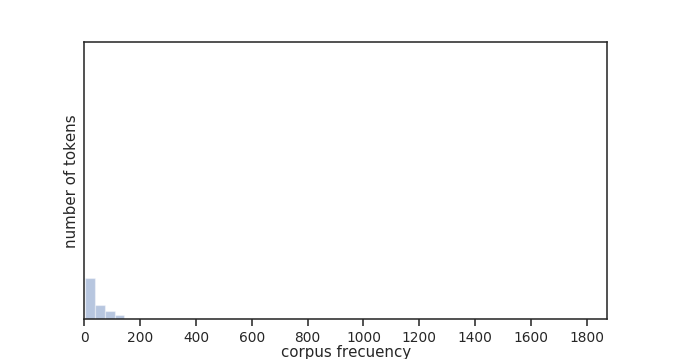

Text(0.5, 0, 'corpus frecuency')

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(7.5,4))
ax = sns.distplot(train_corp_frec.corpus_frecuency, kde=False)
ax.set(yscale="log",ylabel="number of tokens")
ax.set_xticks(range(0,2000,200))
ax.set_xlabel(xlabel="corpus frecuency",labelpad=-.5)
#words_frec_train_set[:10]

In [19]:
tokens_frec_1or2 = len( train_corp_frec[ train_corp_frec['corpus_frecuency']<=3 ] )
print( "Number of word tokens with frecuency on the training corpus <=3: {} ({:0.1f}%)".format 
      (tokens_frec_1or2, 100*tokens_frec_1or2/def_voc_len))

Number of word tokens with frecuency on the training corpus <=2: 5680 (74.6%)


A very small fraction of words have larger frecuencies on the training corpus. Creating a feature per each token of such vocabulary is non-practical (many of them will be meaningless words) and also could induce overfitting, since there are much less  (~5k) SMS messages samples in the dataset.

We have to keep in mind that several of the vocabulary tokens can actually represent a same word (as we saw there can be a lot of misspelling and slang), therefore deriving *n-gram* tokens within word boundaries can lead to a better feature representation.   

For this dataset it is not clear that a **tf-idf** weighting helps considerably, as most of the tokens have low frecuencies. Lets check the tokens with the lowest and largest tf-idf values on the training set:

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizing data using tfidf weighting and default parameters 
vectorizer = TfidfVectorizer().fit(X_train)
X_tt = vectorizer.transform(X_train)

#sorting tokens by idf 
max_tfidf_per_feature = X_tt.max(axis=0).data
idx_sorted = max_tfidf_per_feature.argsort()
sorted_tfidf = max_tfidf_per_feature[idx_sorted]
    
vv = vectorizer.vocabulary_
feat_idx_mapper = dict(zip(vv.values(),vv.keys()))
sorted_feat  = [feat_idx_mapper[i] for i in idx_sorted]

<IPython.core.display.Javascript object>


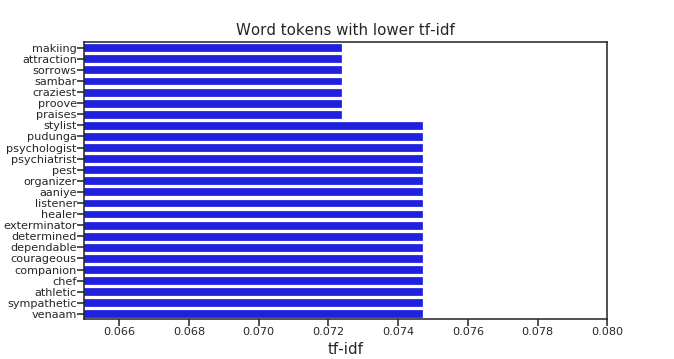

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Word tokens with lower tf-idf')

In [43]:
s=pd.Series(index=sorted_feat,data=sorted_tfidf)
ss = s.iloc[:25].sort_index(ascending=True).sort_values(ascending=True)
plt.figure(figsize=(7.5,4))
ax = sns.barplot(x=ss.data,y=ss.index,orient='h',color='Blue')
ax.set_xlabel("tf-idf",fontsize=12)
ax.set_xlim([0.065,0.08])
ax.tick_params(labelsize=9,which='major',pad=0)
ax.axes.set_title('Word tokens with lower tf-idf')

<IPython.core.display.Javascript object>


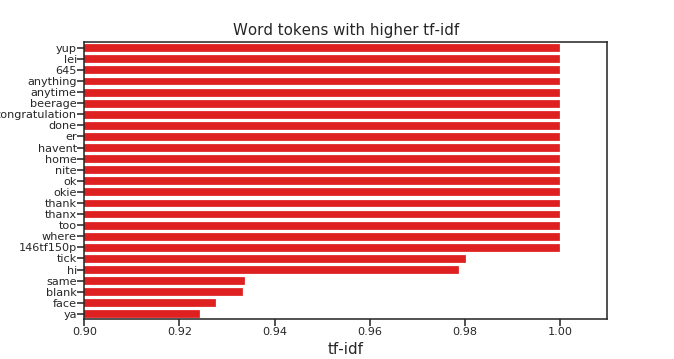

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.data is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Word tokens with higher tf-idf')

In [44]:
sl = s.iloc[-25:].sort_index(ascending=True).sort_values(ascending=False)
plt.figure(figsize=(7.5,4))
ax = sns.barplot(x=sl.data,y=sl.index,orient='h',color='Red')
ax.set_xlabel("tf-idf",fontsize=12)
ax.set_xlim([0.9,1.01])
ax.tick_params(labelsize=9,which='major',pad=0)
ax.axes.set_title('Word tokens with higher tf-idf')